# Neural solver for the 3D Poisson PDE

## Introduction

In this tutorial, we demonstrate the use of `rmldnn` as a **neural PDE solver**
([paper](https://dl.acm.org/doi/10.1145/3458817.3476218)).
The idea is to train a (deep) neural network to learn complex non-linear relationships between inputs and
outputs in a given domain, while minimizing a loss function that represents the residual of the PDE and
its boundary conditions. Once trained, these networks can then be used as fast surrogate models that provide
full-field solutions to PDEs at much lower costs compared to traditional numerical methods (e.g., finite elements).
We will demonstrate the use of `rmldnn` to solve the homogeneous Poisson equation in 3D.


## The Poisson equation
The Poisson equation for the scalar field $u({\bf x})$ can be written as

$$
-\nabla \cdot (\nu({\bf x}) \nabla u({\bf x})) = f({\bf x}) \textrm{ in } D,
$$

where $\nu({\bf x})$ represents the *diffusivity* (or *permeability*) of the medium. Without loss of generality, we consider the homogeneous case where $f({\bf x}) = 0$, and impose the following boundary conditions assuming that $D$ is the unit cube:

\begin{cases}
 & u(0, y, z) = 1, \\
 & u(1, y, z) = 0, \\
 & \frac{\partial u}{\partial n} = 0 \textrm{ on other boundaries }
\end{cases}

The diffusivity map $\nu({\bf x})$ can be any function and, in the scheme of the neural solver, constitutes the input to the neural network. The output of the network will be the solution $u({\bf x})$ to the Poisson PDE.

## Neural network

For our surrogate model, we choose a fully convolutional neural network $G_{nn}$, which has the convenient property of being agnostic to the data size, 
since the filter weights for a convolution operation do not depend on the input resolution. In particular, we will use a standard 3D U-Net architecture:
 
<center><img src="./figures/Unet3D.png" width="750"></center>


A trained U-Net can take a full-field representing the material diffusivity (or forcing function) as input and map it to the full-field solution. In the schematic below,
we show a trained surrogate model $G_{nn}$ in 2D, which takes a matrix $S^d$ (numerical version of $\nu(x)$) as input and maps it to another 
matrix $U^d$ (approximate solution $u(x)$):

<center><img src="./figures/neural_solver.png" width="35%"></center>


## Loss function

We need to formulate a loss function that encapsulates the residual of the PDE and its boundary conditions. When the neural network is trained and this
function is minimized, we will have created a surrogate model capable of producing a full-field solution $u(x)$ that satisfies the PDE given a diffusivity $\nu(x)$.

To that end, we formulate the loss function as the finite-element form of the PDE residual. By applying the standard Galerkin method, we end up with an
energy functional $L(x, \theta)$ that accounts for the PDE and its boundary conditions, and serves as our loss function:

$$
L(\theta) = {1 \over N_s} \sum_{j=1}^{N_s} \int \nu_j(x) |\nabla u_j(x, \theta)|^2 dx ,
$$

where $u_j = G_{nn}(\nu_j, \theta)$ is the desired PDE solution corresponding to the $j^{\rm th}$ sample of the diffusivity,
and $N_s$ is the number of samples.

## Dataset

The diffusivity (or permeability) $\nu(x, \omega)$ is formulated as dependent on a parameter $\omega$, which can be randomly chosen from a parameter space $\Omega$. Thus, by varying $\omega$, we can obtain different diffusivity fields, each rendering a different solution to the above Poisson equation. Therefore, by training the model with input data randomly sampled from $\Omega$, we can obtain a solver for a *family of PDEs* parametrized by $\omega$. In other words, a model can be trained once to learn the correct mapping between input and solution space, and then used multiple times to solve for a family of diffusivity maps, as long as $\omega$ is chosen from the same parameter space $\Omega$.

We will write the parametric diffusivity as the following log permeability expression, typically used in geological simulations and uncertainty quantification:

$$
\nu(x, \omega) = \exp\left( \sum_{j=1}^{m} \omega_i \lambda_i \eta_i(x) \eta_i(y) \eta_i(z) \right),
$$

where $\omega_i$ is an $m$-dimensional parameter, $\lambda_i$ is a vector of real numbers with monotonically decreasing values,
and $\eta_i(x) = {a_i}/2 \cos(a_i x) + sin(a_i x)$ encapsulates the spatial dependency. For our experiments, we will typically use 
$m = 4$, $\omega = [-3, 3]^4$, and $\lambda_i = (1 + 0.25 a_i^2)^{-1}$. A typical 3D diffusivity map generated for a given choice of $\{a_0, \dots, a_3\}$ is shown below.

<center><img src="./figures/diffusivity.png" width="300"></center>

## Training the model

The 2D and 3D Poisson loss functions, as described above, are implemented in `rmldnn` and can be used to train a surrogate model that can serve
as a fast neural solver. The first step is to generate the input training data, which will be diffusivity maps in 3D.
We will use the provided script `diffusivity.py` to generate 16K input samples of size $64 \times 64 \times 64$ into the directory `./diffusivity_maps/`:



In [1]:
!python3 ./diffusivity.py --num_samples 16384 --dir ./diffusivity_maps/ --output_size 64 --dims 3 --cores 4

Command line inputs =  ['./diffusivity.py', '--num_samples', '16384', '--dir', './diffusivity_maps/', '--output_size', '64', '--dims', '3', '--cores', '4']
100%|█████████████████████████████████████| 16384/16384 [14:16<00:00, 19.13it/s]


We can inspect one of the diffusivity maps $\nu(x)$ by looking at its $xz$ cross-sections:

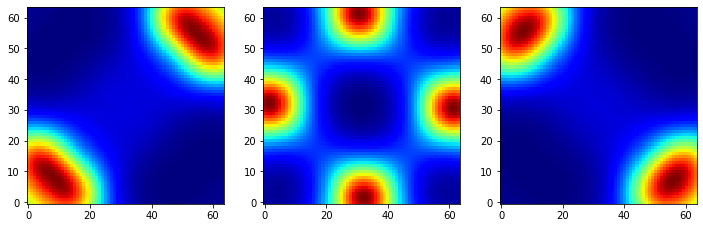

In [2]:
import numpy as np
import matplotlib.pyplot as plt

nu = np.load('./diffusivity_maps/diffusivity_0.npy').squeeze()
fix, ax = plt.subplots(1, 3, figsize=[12, 12])
ax[0].imshow(nu[:, 16, :], origin='lower', cmap='jet')
ax[1].imshow(nu[:, 32, :], origin='lower', cmap='jet')
ax[2].imshow(nu[:, 48, :], origin='lower', cmap='jet')

-----------------------
We will run distributed training for 20 epochs on 4 NVIDIA Tesla-V100 GPUs, using the configuration file below. Notice that:

 - We use the `numpy` data loader to load the diffusivity maps as input data
 - The `Adam` first-order optimizer is used with a learning rate of $1 \times 10^{-4}$
 - The loss function is set to `Poisson3D_PDE`, which implements the finite element-based formulation discussed above
 - We will use a global batch of size 128
 - The neural network used will be a Unet-3D whose description is given in the file `unet3d_poisson.json`

In [ ]:
{
    "neural_network": {
        "outfile": "out_dnn_poisson3d.txt",
        "num_epochs": 20,
        "layers": "./unet3d_poisson.json",
        "checkpoints": {
            "save": "./model_poisson3d/",
            "interval": 5
        },
        "data": {
            "type": "numpy",
            "input_path":  "./diffusivity_maps/",
            "target_path": "./diffusivity_maps/",
            "batch_size": 128,
            "preload": true
        },
        "optimizer": {
            "type": "Adam",
            "learning_rate": 1e-4
        },
        "loss": {
            "function": "Poisson3D_PDE"
        }
    }
}

We can now start training. We will use a Singularity image containing rmldnn
(see [instructions](https://github.com/rocketmlhq/rmldnn#install) on how to download the image).
Alternatively, one could use a Docker image or a native build on the cloud
(see [usage](https://github.com/rocketmlhq/rmldnn#usage) section for details).

Notice that the rmldnn command takes an extra parameter in this case, `--app=pde`, which engages the neural solver module:

In [ ]:
!singularity exec --nv ./rmldnn_image.sif mpirun -np 4 -x CUDA_VISIBLE_DEVICES=0,1,2,3 \
 rmldnn --app=pde --config= ./config_poisson3d_pde.json

In our system, training took about 2 minutes per epoch.

We can monitor the run by looking at how the loss value changes with time, which is reported in the log file `out_dnn_poisson3d_train.txt`:

<center><img src="./figures/loss.png" width="500"></center>

## Running inference on a trained model

The model we just trained can now serve as a neural solver for the 3D Poisson PDE. By using it to run inference on a new input sample, 
we are essentially solving the Poisson equation on a domain of size $64^3$, with the boundary conditions given above, for a new diffusivity 
$\nu(x)$ passed in as input, as illustrated below. Given a numpy file `nu.npy` containing $\nu(x)$, the following config file can be used to solve the 3D Poisson equation and write out the solution to `./prediction/output_1.h5`:

In [ ]:
{
    "neural_network": {
        "layers": "./unet3d_poisson.json",
        "checkpoints": {
            "load": "./model_poisson3d/model_checkpoint_20.pt"
        },
        "data": {
            "type": "numpy",
            "test_input_path":  "./data/nu.npy",
            "test_target_path": "./data/nu.npy",
            "test_output_path": "./prediction/"
        },
        "loss": {
            "function": "Poisson3D_PDE"
        }
    }
}

In [ ]:
!singularity exec --nv ./rmldnn_image.sif rmldnn --app=pde --config= ./config_poisson3d_pde_inference.json

<center><img src="./figures/inference.jpg" width="1000"></center>

## Checking the results



In order to assess the quality of the neural solver solution, we have also solved the Poisson PDE with the diffusivity used above via a standard finite-element solver -- the result is in the file `fem.npy`. 
The code below plots cross-sections of both neural-based and FEM-based solutions along the $xz$ plane for several values of $y$, and computes the error between them.

In [4]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

def display_slice(nu, pred, truth):
    fig, ax = plt.subplots(1, 4, figsize=[18, 18])
    #fig.suptitle('Vertically stacked subplots')
    ax[0].set_title('Input')
    im0 = ax[0].imshow(nu, origin='lower', cmap='jet')
    ax[1].set_title('rmldnn')
    im1 = ax[1].imshow(pred, origin='lower', cmap='jet', vmin=0, vmax=1)
    ax[2].set_title('FEM')
    im2 = ax[2].imshow(truth, origin='lower', cmap='jet', vmin=0, vmax=1)
    ax[3].set_title('Error')
    im3 = ax[3].imshow(pred - truth, origin='lower', cmap='jet')
    fig.colorbar(im0, ax = ax[0], shrink=0.2)
    fig.colorbar(im1, ax = ax[1], shrink=0.2)
    fig.colorbar(im2, ax = ax[2], shrink=0.2)
    fig.colorbar(im3, ax = ax[3], shrink=0.2)
    plt.show()    

nu   = np.load('./data/nu.npy').squeeze()
fem  = np.load('./data/fem.npy')
pred = h5.File('./prediction/output_1.h5', 'r')['nu.npy'][()].squeeze()

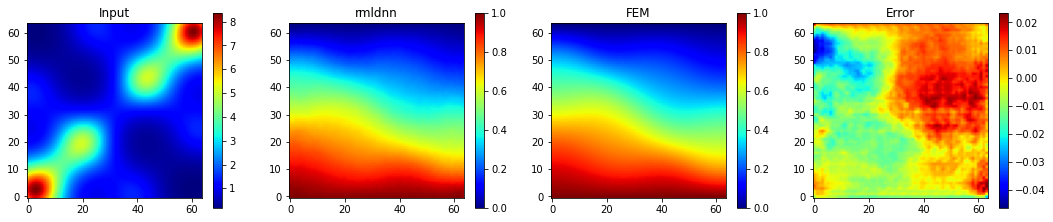

In [5]:
y = 16
display_slice(nu[:, y, :], pred[:, y, :], fem[:, y, :])

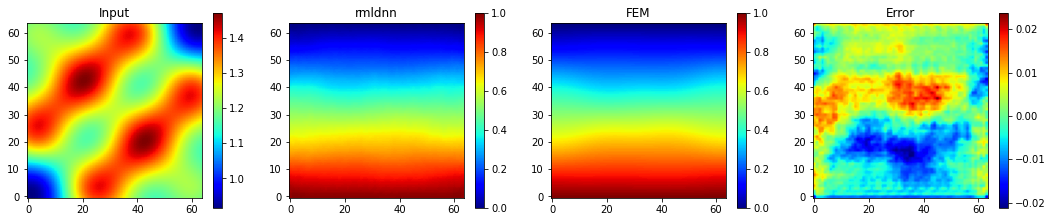

In [6]:
y = 32
display_slice(nu[:, y, :], pred[:, y, :], fem[:, y, :])

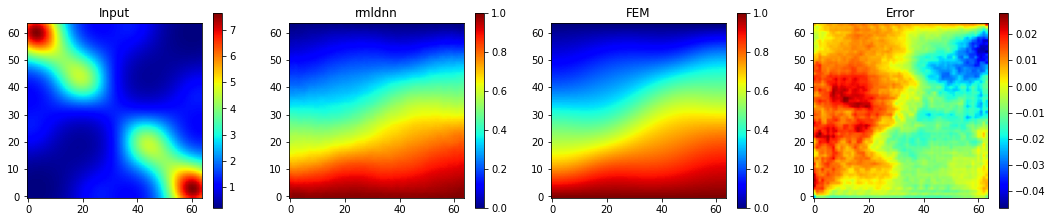

In [7]:
y = 48
display_slice(nu[:, y, :], pred[:, y, :], fem[:, y, :])

Notice that the error values are close to two orders of magnitude smaller than typical values in the solution,
indicating an excellent agreement between the neural-based and the FEM-based solutions. 